# Time to slice and dice

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [3]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.8 MB/s eta 0:00:00


In [4]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"
!unzip drugsCom_raw.zip

--2023-12-11 09:16:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘drugsCom_raw.zip’

drugsCom_raw.zip        [          <=>       ]  41.00M  16.8MB/s    in 2.4s    

2023-12-11 09:16:16 (16.8 MB/s) - ‘drugsCom_raw.zip’ saved [42989872]

Archive:  drugsCom_raw.zip
  inflating: drugsComTest_raw.tsv    
  inflating: drugsComTrain_raw.tsv   


In [5]:
from datasets import load_dataset

data_files = {"train": "drugsComTrain_raw.tsv", "test": "drugsComTest_raw.tsv"}
# \t is the tab character in Python
drug_dataset = load_dataset("csv", data_files=data_files, delimiter="\t")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

**Data Analysis**\
Similar to Pandas, 🤗 Datasets provides several functions to manipulate the contents of Dataset and DatasetDict objects.


In [6]:
drug_sample = drug_dataset["train"].shuffle(seed=42).select(range(1000))
# Peek at the first few examples
drug_sample[:3]

{'Unnamed: 0': [87571, 178045, 80482],
 'drugName': ['Naproxen', 'Duloxetine', 'Mobic'],
 'condition': ['Gout, Acute', 'ibromyalgia', 'Inflammatory Conditions'],
 'review': ['"like the previous person mention, I&#039;m a strong believer of aleve, it works faster for my gout than the prescription meds I take. No more going to the doctor for refills.....Aleve works!"',
  '"I have taken Cymbalta for about a year and a half for fibromyalgia pain. It is great\r\nas a pain reducer and an anti-depressant, however, the side effects outweighed \r\nany benefit I got from it. I had trouble with restlessness, being tired constantly,\r\ndizziness, dry mouth, numbness and tingling in my feet, and horrible sweating. I am\r\nbeing weaned off of it now. Went from 60 mg to 30mg and now to 15 mg. I will be\r\noff completely in about a week. The fibro pain is coming back, but I would rather deal with it than the side effects."',
  '"I have been taking Mobic for over a year with no side effects other than 

In [7]:
drug_dataset["train"].features

{'Unnamed: 0': Value(dtype='int64', id=None),
 'drugName': Value(dtype='string', id=None),
 'condition': Value(dtype='string', id=None),
 'review': Value(dtype='string', id=None),
 'rating': Value(dtype='float64', id=None),
 'date': Value(dtype='string', id=None),
 'usefulCount': Value(dtype='int64', id=None)}

In [8]:
# To check if Unnamed: 0 column has unique values
for split in drug_dataset.keys():
    assert len(drug_dataset[split]) == len(drug_dataset[split].unique("Unnamed: 0"))

In [9]:
# It is unique, so let's rename it
drug_dataset = drug_dataset.rename_column(
    original_column_name="Unnamed: 0", new_column_name="patient_id"
)
drug_dataset

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount'],
        num_rows: 53766
    })
})

In [10]:
# Let's try to lowercase the field 'condition'
def lowercase_condition(example):
    return {"condition": example["condition"].lower()}


drug_dataset.map(lowercase_condition)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

AttributeError: ignored

In [22]:
def filter_nones(x):
    return x["condition"] is not None

In [23]:
# lambda function
print((lambda x: x * x)(3))
print((lambda base, height: 0.5 * base * height)(4, 8))

9
16.0


In [24]:
#filter: Takes function as argument, that function should return True or False for each element
drug_dataset = drug_dataset.filter(lambda x: x["condition"] is not None)

Filter:   0%|          | 0/161297 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53766 [00:00<?, ? examples/s]

In [25]:
drug_dataset = drug_dataset.map(lowercase_condition)
# Check that lowercasing worked
drug_dataset["train"]["condition"][:3]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

['left ventricular dysfunction', 'adhd', 'birth control']

**Creating new column**
1. Dataset.map-
  - Argument is function where can return a dictionary corresponding to each item in dataset. New keys will be added while the existing ones will be updated.
  - Using Dataset.map() with batched=True will be essential to unlock the speed of the “fast” tokenizers
2. Dataset.add_column()- provide Python list or nump array

In [26]:
def compute_review_length(example):
  # key "review_length" doesn't exist. So, new column will be created
  return {"review_length": len(example["review"].split())}

In [27]:
drug_dataset = drug_dataset.map(compute_review_length)
# Inspect the first training example
drug_dataset["train"][0]

Map:   0%|          | 0/160398 [00:00<?, ? examples/s]

Map:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'patient_id': 206461,
 'drugName': 'Valsartan',
 'condition': 'left ventricular dysfunction',
 'review': '"It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"',
 'rating': 9.0,
 'date': 'May 20, 2012',
 'usefulCount': 27,
 'review_length': 17}

In [28]:
print(drug_dataset["train"].sort("review_length", reverse=True)[:3])# Len [1894, 1162, 1107]
print(drug_dataset["train"].sort("review_length")[:3])

{'patient_id': [121004, 181160, 216072], 'drugName': ['Venlafaxine', 'Prozac', 'Copper'], 'condition': ['migraine', 'obsessive compulsive disorde', 'birth control'], 'review': ['"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn\'t want to. Not normal for a usually outgoing extrovert.\r\nNow, I\'m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; kee

In [29]:
drug_dataset = drug_dataset.filter(lambda x: x["review_length"] > 30)
print(drug_dataset.num_rows)

Filter:   0%|          | 0/160398 [00:00<?, ? examples/s]

Filter:   0%|          | 0/53471 [00:00<?, ? examples/s]

{'train': 138514, 'test': 46108}


In [30]:
# Removing html character
import html

text = "I&#039;m a transformer called BERT"
html.unescape(text)

"I'm a transformer called BERT"

In [31]:
drug_dataset = drug_dataset.map(lambda x: {"review": html.unescape(x["review"])})

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [32]:
# map function with batch argumentm check the examples/s
new_drug_dataset = drug_dataset.map(
    lambda x: {"review": [html.unescape(o) for o in x["review"]]}, batched=True
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [40]:
new_drug_dataset.column_names

{'train': ['patient_id',
  'drugName',
  'condition',
  'review',
  'rating',
  'date',
  'usefulCount',
  'review_length'],
 'test': ['patient_id',
  'drugName',
  'condition',
  'review',
  'rating',
  'date',
  'usefulCount',
  'review_length']}

**Fast vs Slow Tokenizers**

In [15]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["review"], truncation=True)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [16]:
%time tokenized_dataset = drug_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/161297 [00:00<?, ? examples/s]

Map:   0%|          | 0/53766 [00:00<?, ? examples/s]

CPU times: user 2min 8s, sys: 810 ms, total: 2min 9s
Wall time: 1min 34s


In [22]:
slow_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=False)



def slow_tokenize_function(examples):
    return slow_tokenizer(examples["review"], truncation=True)



In [23]:
%time tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 6min 25s, sys: 1.71 s, total: 6min 27s
Wall time: 6min 44s


In [24]:
# We can vary the number of processes to get more speedup
%time tokenized_dataset = drug_dataset.map(slow_tokenize_function, batched=True, num_proc=8)

Map (num_proc=8):   0%|          | 0/138514 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/46108 [00:00<?, ? examples/s]

CPU times: user 6.87 s, sys: 738 ms, total: 7.61 s
Wall time: 7min 27s


Fast Tokenizers are able to achieve such a speedup because behind the scenes the tokenization code is executed in Rust, which is a language that makes it easy to parallelize code execution.

In general, we don't recommend using Python multiprocessing for fast tokenizers with batched=True.

**Time Comparison**

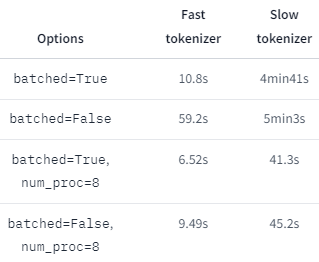

In [41]:
# Tokenizer removed the original columns automatically
tokenized_dataset.column_names

{'train': ['input_ids',
  'token_type_ids',
  'attention_mask',
  'overflow_to_sample_mapping'],
 'test': ['input_ids',
  'token_type_ids',
  'attention_mask',
  'overflow_to_sample_mapping']}

**Return more than one feature**

How to handle column size issue
1. Remove original columns
2. Create duplicate copies of column in original dataset to match the new column size

In [33]:
def tokenize_and_split(examples):
    return tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )

In [45]:
result = tokenize_and_split(drug_dataset["train"][:2])
print(result.keys())
print([len(inp) for inp in result["input_ids"]])
print(result['overflow_to_sample_mapping'])# Mapping relative to the dataset slice passed

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping'])
[128, 49, 128, 55]
[0, 0, 1, 1]


In [35]:
"""
Default batch size is 1000
"""
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

ArrowInvalid: ignored

In [36]:
# Remove Columns
tokenized_dataset = drug_dataset.map(
    tokenize_and_split, batched=True, remove_columns=drug_dataset["train"].column_names
)

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

In [43]:
print(tokenized_dataset.column_names)
print(len(tokenized_dataset["train"]), len(drug_dataset["train"]))

{'train': ['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping'], 'test': ['input_ids', 'token_type_ids', 'attention_mask', 'overflow_to_sample_mapping']}
206772 138514


In [46]:
# Making the old columns the same size as the new ones.
def tokenize_and_split(examples):
    result = tokenizer(
        examples["review"],
        truncation=True,
        max_length=128,
        return_overflowing_tokens=True,
    )
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in examples.items():
        result[key] = [values[i] for i in sample_map]
    return result

In [47]:
tokenized_dataset = drug_dataset.map(tokenize_and_split, batched=True)
tokenized_dataset

Map:   0%|          | 0/138514 [00:00<?, ? examples/s]

Map:   0%|          | 0/46108 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 206772
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 68876
    })
})

In [48]:
print(tokenized_dataset.column_names)
print(len(tokenized_dataset["train"]), len(drug_dataset["train"]))

{'train': ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask'], 'test': ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'input_ids', 'token_type_ids', 'attention_mask']}
206772 138514


## From Datasets to DataFrames and back

To enable the conversion between various third-party libraries, 🤗 Datasets provides a **Dataset.set_format()** function. This function only changes the output format of the dataset, so you can easily switch to another format without affecting the underlying data format, which is Apache Arrow.

In [49]:
drug_dataset.set_format("pandas")

In [50]:
# DataFrame instead of a dictionary
drug_dataset["train"][:3]

,patient_id,drugName,condition,review,rating,date,usefulCount,review_length
0,95260,Guanfacine,adhd,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,141
1,92703,Lybrel,birth control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,134
2,138000,Ortho Evra,birth control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,89


In [52]:
print(type(drug_dataset))

<class 'datasets.dataset_dict.DatasetDict'>


In [51]:
# Dataframe for the whole training dataset
train_df = drug_dataset["train"][:]

In [54]:
frequencies = (
    train_df["condition"]
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={"index": "condition", "condition": "frequency"})
)
frequencies.head()

,condition,frequency
0,birth control,27655
1,depression,8023
2,acne,5209
3,anxiety,4991
4,pain,4744


**Dataset from pandas**

In [55]:
from datasets import Dataset

freq_dataset = Dataset.from_pandas(frequencies)
freq_dataset

Dataset({
    features: ['condition', 'frequency'],
    num_rows: 819
})

In [62]:
#  Try it out! Compute the average rating per drug and store the result in a new Dataset.
Dataset.from_pandas(train_df.groupby('drugName')['rating'].mean().reset_index())

Dataset({
    features: ['drugName', 'rating'],
    num_rows: 3052
})

**Creating a validation set**

Dataset.train_test_split()

In [64]:
# reset the output format of drug_dataset from "pandas" to "arrow"
drug_dataset.reset_format()

In [65]:
drug_dataset_clean = drug_dataset["train"].train_test_split(train_size=0.8, seed=42)
# Rename the default "test" split to "validation"
drug_dataset_clean["validation"] = drug_dataset_clean.pop("test")
# Add the "test" set to our `DatasetDict`
drug_dataset_clean["test"] = drug_dataset["test"]
drug_dataset_clean

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

**Saving a dataset**

|Data format	|Function|
| -------- | ------- |
|Arrow	|Dataset.save_to_disk()|
|CSV	|Dataset.to_csv()|
|JSON	|Dataset.to_json()|

In [66]:
drug_dataset_clean.save_to_disk("drug-reviews")

Saving the dataset (0/1 shards):   0%|          | 0/110811 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/27703 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/46108 [00:00<?, ? examples/s]

In [69]:
!ls -R drug-reviews

drug-reviews:
dataset_dict.json  test  train	validation

drug-reviews/test:
data-00000-of-00001.arrow  dataset_info.json  state.json

drug-reviews/train:
data-00000-of-00001.arrow  dataset_info.json  state.json

drug-reviews/validation:
data-00000-of-00001.arrow  dataset_info.json  state.json


In [70]:
from datasets import load_from_disk

drug_dataset_reloaded = load_from_disk("drug-reviews")
drug_dataset_reloaded

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 110811
    })
    validation: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 27703
    })
    test: Dataset({
        features: ['patient_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length'],
        num_rows: 46108
    })
})

**For the CSV and JSON formats, we have to store each split as a separate file.**

In [71]:
for split, dataset in drug_dataset_clean.items():
    dataset.to_json(f"drug-reviews-{split}.jsonl")

Creating json from Arrow format:   0%|          | 0/111 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/28 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/47 [00:00<?, ?ba/s]

In [72]:
!head -n 1 drug-reviews-train.jsonl

{"patient_id":89879,"drugName":"Cyclosporine","condition":"keratoconjunctivitis sicca","review":"\"I have used Restasis for about a year now and have seen almost no progress.  For most of my life I've had red and bothersome eyes. After trying various eye drops, my doctor recommended Restasis.  He said it typically takes 3 to 6 months for it to really kick in but it never did kick in.  When I put the drops in it burns my eyes for the first 30 - 40 minutes.  I've talked with my doctor about this and he said it is normal but should go away after some time, but it hasn't. Every year around spring time my eyes get terrible irritated  and this year has been the same (maybe even worse than other years) even though I've been using Restasis for a year now. The only difference I notice was for the first couple weeks, but now I'm ready to move on.\"","rating":2.0,"date":"April 20, 2013","usefulCount":69,"review_length":147}


In [73]:
# To reload from the json files
data_files = {
    "train": "drug-reviews-train.jsonl",
    "validation": "drug-reviews-validation.jsonl",
    "test": "drug-reviews-test.jsonl",
}
drug_dataset_reloaded = load_dataset("json", data_files=data_files)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]